In [1]:
import os
import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.distributions import Normal, kl_divergence, MixtureSameFamily, Categorical
from PIL import Image
import numpy as np
import random as rnd
from torch.utils.tensorboard import SummaryWriter
import torch.utils.tensorboard

import scipy.stats as sts
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib import patches

# from fonctions_utiles import niveau_gris, niveau_gris_moyen
import fonctions_utiles as f

### Importer une partie de CelebA

In [2]:

# Chemin vers le dossier contenant les images 
folder_path = 'img_align_celeba'

# Chemin vers le fichier d'attributs CelebA (list_attr_celeba.txt)
attributes_path = 'list_attr_celeba.txt'
landmarks_path = 'list_landmarks_align_celeba.txt'
box_path = 'list_bbox_celeba.txt'

# Définir les attributs souhaitées 
desired_attributes = {    #total in dataset 205 599
    'No_Beard',    #169 158
    'Young',       #156 734
#    'Attractive',  #103 833
#    'Smiling',     # 97 669
#    'Male',        # 84 434
#    'Wavy_Hair',   # 64 744
#    'Oval_Face',   # 57 567
#    'Brown_Hair',  # 41 572
#    'Bangs',       # 30 709
   'Eyeglasses',  # 13 193
#    'Blurry',      # 10 312
#    'Mustache',    #  8 417
#    'Bald',        #  4 547
}


# Définir les transformations (ajustez selon les besoins)
size_img_1 = 128
size_img_2 = 128


# Charger les attributs depuis le fichier
with open(attributes_path, 'r') as file:
    lines = file.readlines()

# Extraire les noms d'attributs à partir du fichier
attr_names = lines[1].split()

# Filtrer les indices des exemples en fonction des attributs souhaités
preselected_indices = []
for i, line in enumerate(lines[2:]): # on commence à l'indice 0 pour l'image 000001.jpeg, donc i <->  f'{i+1:06d}.jpg'
    attributes = line.split()
    if all(attributes[attr_names.index(attr)+1] == '1' for attr in desired_attributes):
        preselected_indices.append(i)

In [3]:
# selected_indices = []
# NIV_GRIS = 0.75

# for i, i_pre in enumerate(preselected_indices):
#     if i%1000== 0: 
#         percentage = i * 100 / len(preselected_indices)
#         print(f"{i}, env {percentage:.3f}%")            

#     img_path = os.path.join(folder_path, f'{i_pre+1:06d}.jpg')
#     img = Image.open(img_path).convert('RGB')
#     transform_tensor = transforms.ToTensor()
#     image_tensor = transform_tensor(img)
#     niv_gris = f.niveau_gris(image_tensor, taille = 20)
    
#     if niv_gris > NIV_GRIS : 
#         selected_indices.append(i_pre)

In [4]:
# PATH = r'C:\Users\salvador\Documents\VSCode\mcVAE_CelebA\index_lists\indice_list_NoBeard_Young_Eyeglasses_75.npy'
# np.save(PATH, selected_indices)


In [5]:
# PATH = r'C:\Users\salvador\Documents\VSCode\mcVAE_CelebA\index_lists\indice_list_NoBeard_Young_75.npy'
PATH = r'C:\Users\salvador\Documents\VSCode\mcVAE_CelebA\index_lists\indice_list_NoBeard_Young_6.npy'
# PATH = r'C:\Users\salvador\Documents\VSCode\mcVAE_CelebA\index_lists\indice_list_NoBeard_Young_Eyeglasses_75.npy'
selected_indices = np.load(PATH)

#### Customs Datasets

In [6]:
# Liste des chemins d'accès aux images correspondant aux indices sélectionnés
# on commence à l'indice 0 pour l'image 000001.jpeg, donc i <->  f'{i+1:06d}.jpg' 
image_paths = [os.path.join(folder_path, f'{i+1:06d}.jpg') for i in selected_indices]

from customs_datasets import *

#_______________________________________________________________________________
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((size_img_1, size_img_2))
])

transform_land = transforms.Compose([
    transforms.Resize((size_img_1, size_img_2))
])


# Lire les landmarks depuis le fichier
landmarks = np.loadtxt(landmarks_path, skiprows=2, usecols=range(1, 11))

# Charger le dataset en filtrant les images selon les indices sélectionnés
selected_dataset = CustomImageLandmarksDataset(image_paths, 
                                                  landmarks[selected_indices], 
                                                  transform=transforms.ToTensor())
selected_dataset_img = CustomImageDataset(image_paths, 
                                          transform)
selected_dataset_img_BW = CustomImageDataset_BW(image_paths, 
                                          transform)
selected_dataset_land_bin = CustomImageLandmarksBinaryDataset(image_paths, 
                                                  landmarks[selected_indices], 
                                                  transform=transform,
                                                  transform_land=transform_land)


# Diviser le Subset en ensembles d'entraînement et de test (70%  train,  20% validation,  10% test)
train_size = int(0.7 * len(selected_dataset_land_bin))
valid_size = int(0.2 * len(selected_dataset_land_bin))
test_size = len(selected_dataset_land_bin) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(selected_dataset_land_bin, 
                                                          [train_size, valid_size, test_size])

# Utiliser un DataLoader pour charger les données en lots
batch_size = 64
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Defining a model: Multi-channel Variational Autoencoder
In this excercise we will use the Multi-channel Variational Autoencoder proposed by Antelmi _et_ al.

In [7]:
#!pip install -q git+https://gitlab.inria.fr/epione_ML/mcvae.git

!pip install --upgrade mcvae

In [8]:
from mcvae.models import Mcvae_fusion

from mcvae.models import VAE
from mcvae.models import ConvVAE
from mcvae.distributions import Normal, GaussianMixture

                                           uuid  \
index                                             
0      GPU-610199b5-7946-35d1-92ae-e151e2bd5a7a   

                                            name temperature.gpu  \
index                                                              
0      NVIDIA RTX 2000 Ada Generation Laptop GPU              55   

      utilization.gpu memory.used memory.total  
index                                           
0                   0           0         8188  


## MC-F-VAE PoE Image/Image bruitee

#### Méthode de fusion

produit d'expert : 
Un produit de gaussienne $\mathcal N (\mu_i, \Sigma_i)$ avec des poids $\alpha_i$ est une gaussienne $\mathcal N(\mu, \Sigma)$, avec $ \mu$ et $\Sigma$ tels que : 
$$ \mu = \left( \sum_i \alpha_i \mu_i T_i \right)\left( \sum_i \alpha_i T_i\right)^{-1}$$
$$\Sigma = \left( \sum_i \alpha_i T_i\right)^{-1} \text{  où  } T_i = \Sigma_i^{-1}$$

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def PoE (list_of_gauss, weights=None):
    if weights is None:
        weights = [1 for _ in list_of_gauss] #PoE weight puisance  : pas de poids --> tous à 1

    list_loc = [el.loc for el in list_of_gauss]
    list_scale = [el.scale for el in list_of_gauss]
    loc_prod = 0
    scale_prod = 0
    for i, loc in enumerate(list_loc):
        t = list_scale[i]**(-1)
        w = weights[i]
        loc_prod+= w*loc*t
        scale_prod+= w*t
   
    scale_prod = scale_prod**(-1)
    loc_prod = loc_prod*scale_prod
    return Normal(loc=loc_prod, scale=scale_prod)

In [11]:
def MoE (list_of_gauss, weights=None):
    n = len(list_of_gauss)
    if weights is None:
        weights = torch.ones(n,).to(DEVICE)  #MoE weight facteur  : pas de poids --> tous à 1
    weights = weights.to(DEVICE)
    locs = torch.stack([el.loc[0] for el in list_of_gauss]).reshape((-1, n)).to(DEVICE)
    scales = torch.stack([el.scale[0] for el in list_of_gauss]).reshape((-1, n)).to(DEVICE)
    mix = Categorical(weights)
    comp = Normal(
        locs, scales)
    return MixtureSameFamily(mix, comp)

### Paramètres

In [12]:
N_EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-4           # Learning rate
LAT_DIM = 32      # Size of the latent space for this autoencoder
BETA =  0.001         # balance parameter between ll and kl losses loss = beta*kl - ll
N_CHANNELS = 2
TYPE_FUSION = MoE   #type de fuusion MoE ou PoE
LOSS_FUS = True    #si loss_fus = False : on utilise la loss non modifié du modèle d'alignement
                    # si loss-fus = True on utilise la loss fusion : calcule KL quand c'est possible et MC à 100 sinon
LOSS_Modif = False  # LOSS_Modif à défaut sur false, 
                    # pris en comptte que lors de l'utilisation de Loss fusion et change le montecarlo à 100, 
                    # en monte carlo partiel

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)
VAE_CLASSES = [ConvVAE, ConvVAE] # Architecture of the autoencoder (VAE: three layers of convolution and one linear)

Shape_c_1 = (1, size_img_1, size_img_2) # Number of pixels in an CaelebA image after reshape
Shape_c_2 = (1, size_img_1, size_img_2) #Image binaire des landmarks

dummy_data = [torch.zeros(Shape_c_1).to(DEVICE), torch.zeros( Shape_c_2).to(DEVICE)]  # Dummy data to initialize the input layer size


model = Mcvae_fusion(data=dummy_data, 
              n_channels=N_CHANNELS,
              n_feats = (Shape_c_1, Shape_c_2), 
              lat_dim=LAT_DIM, 
              vaeclass=VAE_CLASSES,
              beta = BETA,
              loss_fusion = LOSS_FUS,
              loss_modif = LOSS_Modif,
              fusion = TYPE_FUSION).to(DEVICE) # channel 1 : image, channel 2 : image binaire des landmarks
model.optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
model.init_loss()
model.init_validation_loss()



Device: cuda


### Entrainement


In [13]:
# Entrainement du modèle

init_params = model.state_dict()
# Load data in the form of a tensor
#train data
X = f.get_data(train_dataset, batch_size=BATCH_SIZE)#.to(DEVICE)
AA = torch.empty(size= (N_CHANNELS, BATCH_SIZE, *Shape_c_1))
AA[0] = X[0]
AA[1] = X[1]
model.data = AA.to(DEVICE) #torch.Tensor.reshape(X, shape= (N_CHANNELS, BATCH_SIZE, 1, *Shape_c_1, *Shape_c_2))

#validation data
Y = f.get_data(train_dataset, batch_size=BATCH_SIZE)#.to(DEVICE)
valid_data_tensor = Y #torch.Tensor.reshape(Y, shape= (N_CHANNELS, BATCH_SIZE, 1, size_img_1, size_img_2))

writer = SummaryWriter()
# Load  parameters and train
model.load_state_dict(init_params)
model.optimize(epochs=N_EPOCHS, data=model.data, validation_data = valid_data_tensor)

C:\Users\salvador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


cuda:0
--fusion faite ---
cuda:0
cuda:0


RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [ ]:
# nom_model = f'\MC_F_PoE_VAE_loss_align_2chan__imgBW_lan_bin_{LAT_DIM}lat'
# nom_model = f'\MC_F_PoE_VAE_loss_fus_2chan__imgBW_land_bin_{LAT_DIM}lat'

# nom_model = f'\MC_F_MoE_VAE_loss_align_2chan__imgBW_land_bin_{LAT_DIM}lat'
# nom_model = f'\MC_F_MoE_VAE_loss_fus_2chan__imgBW_land_bin_{LAT_DIM}lat'
# PATH = r'C:\Users\salvador\Documents\VSCode\mcVAE_CelebA\fusion_models'+nom_model
# torch.save(model, PATH)

In [ ]:
LAT_DIM = 32

# nom_model = f'\MC_F_PoE_VAE_loss_align_2chan__imgBW_lan_bin_{LAT_DIM}lat'
# nom_model = f'\MC_F_PoE_VAE_loss_fus_2chan__imgBW_land_bin_{LAT_DIM}lat'

# nom_model = f'\MC_F_MoE_VAE_loss_align_2chan__imgBW_land_bin_{LAT_DIM}lat'
# nom_model = f'\MC_F_MoE_VAE_loss_fus_2chan__imgBW_land_bin_{LAT_DIM}lat'

# PATH = r'C:\Users\salvador\Documents\VSCode\mcVAE_CelebA\fusion_models'+nom_model
# model_loaded = torch.load(PATH)

In [ ]:
model_loaded = model

### Reconstruire les images

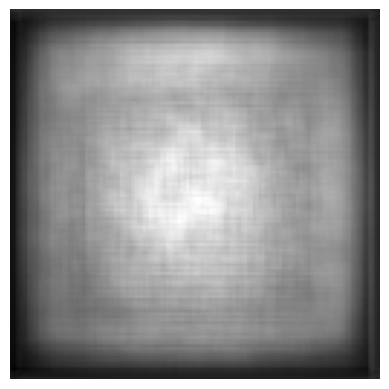

In [ ]:
i = np.random.randint(len(selected_dataset_img))
Y = f.get_data(selected_dataset_land_bin[i]).to(DEVICE)
Y_tensor = torch.Tensor.reshape(Y, shape= (N_CHANNELS, 1, 1, size_img_1, size_img_2))

x_hat = model_loaded.reconstruct(Y_tensor)

x_rec = torch.zeros([1, size_img_1, size_img_2], device='cpu',)
x_rec[0] = x_hat[0]

f.plot_img_bw(x_rec)

In [ ]:
def reconstruction(point_original, channel = 0):
    Y = f.get_data(point_original).to(DEVICE)
    Y_tensor = torch.Tensor.reshape(Y, shape= (N_CHANNELS, 1, 1, size_img_1, size_img_2))

    x_hat = model_loaded.reconstruct(Y_tensor) #renvoie un liste de tenseurs 

    x_rec = torch.zeros([1, size_img_1, size_img_2], device='cpu',)
    x_rec[0] = x_hat[channel]

    return x_rec

def plot_img_comp(point_original): 

    plt.figure()

    plt.subplot(1,2,1)
    f.plot_img_bw(point_original[0])
    plt.title('original picture')

    plt.subplot(1,2,2)
    rec_img = reconstruction(point_original, channel=0).detach().numpy()
    np.clip(rec_img[0], 0, 1, out=rec_img)
    f.plot_img_bw(rec_img)
    plt.title('reconstruction')

with sample from test dataset


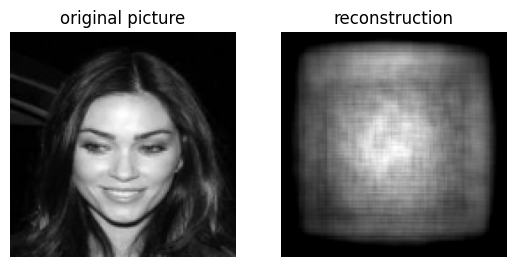

In [ ]:
N = 1

print('with sample from test dataset')
for _ in range(N):
    i = np.random.randint(len(test_dataset))
    point_original = test_dataset[i]

    plot_img_comp(point_original)

### Pairplot espace latent

In [ ]:
#on calcule les moyennes des représentations de nb_points 

def calcul_points_pairplot_mccvae_fusion(list_ind_point = np.arange(100), 
                                  data = selected_dataset_land_bin, 
                                  mod = model_loaded):
    chan = mod.n_channels
    lat = mod.lat_dim
    nb_points = len(list_ind_point)
    array_z = np.zeros((nb_points, 1, lat))

    for i, ind in enumerate(list_ind_point):
        Y = f.get_data(data[ind]).to(DEVICE)
        data_tensor = torch.Tensor.reshape(Y, shape= (chan, 1, 1, size_img_1, size_img_2))

        q = mod.forward(data_tensor)['q']
        mu = q.loc.squeeze()
        array_z[i][0] = mu.detach().cpu().numpy()
    return array_z


In [ ]:
nb_points = 500
list_ind_point = rnd.sample(range(0, len(test_dataset)), nb_points)
array_z_land_bin = calcul_points_pairplot_mccvae_fusion(list_ind_point = list_ind_point, 
                                                        data = selected_dataset_land_bin, 
                                                        mod = model_loaded)


In [ ]:
list_points = []
for i in list_ind_point:
    list_points.append( test_dataset[i][0].flatten().numpy()  )

list_points = np.array(list_points)

# list_points_land_bin = []
# for i in list_ind_point:
#     list_points_land_bin.append( test_dataset[i][1].flatten().numpy()  )

# list_points_land_bin = np.array(list_points_land_bin)

In [ ]:
# on choisit selon quel attribut / indice calculé on va colorer les points
# indice = f.orientation           # prend en entrée selected_dataset[i]
indice = f.sourire               # prend en entrée selected_dataset[i]
# indice = f.niveau_gris_moyen       # prend en entrée selected_dataset_img[i]
#______________________

indice_color = np.zeros(nb_points)

for i in range(nb_points):
    indice_color[i] = indice(selected_dataset[i])       # changer ici selected_dataset ou selected_dataset_img selon l'indice choisit


In [ ]:
array_z_land_bin.squeeze().shape

(500, 32)

In [ ]:
from sklearn.cross_decomposition import PLSRegression

numDimsToPlot = 1

### TODO: create a PLS model with numDimsToPlot components
pls = PLSRegression(n_components=numDimsToPlot)

### TODO: fit the model
pls.fit(array_z_land_bin.squeeze(), indice_color)


PLSRegression(n_components=1)

In [ ]:
np.corrcoef(pls.x_scores_[:,0], indice_color)
# donne la matrice de covariance, on récupère la valeur en [0, 1] ou [1, 0]

array([[ 1.        , -0.05774969],
       [-0.05774969,  1.        ]])

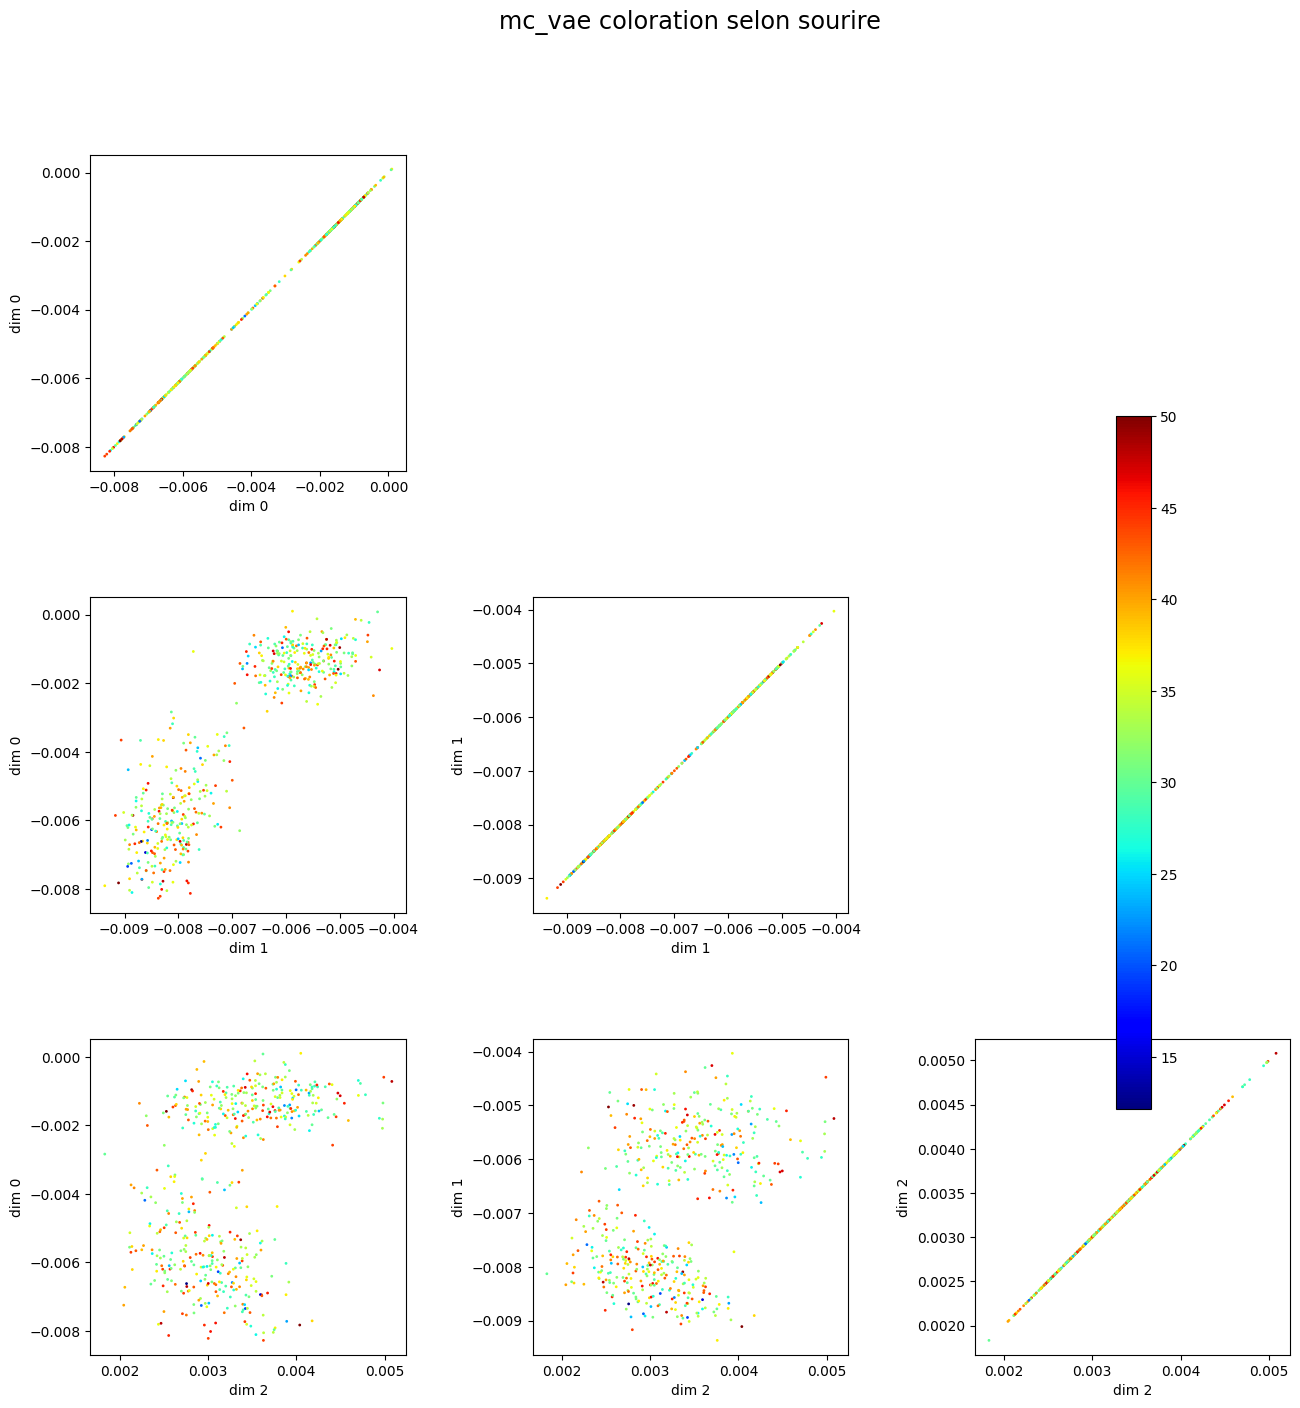

In [ ]:
LIST_DIM_PAIR_PLOT = [0, 1, 2]

f.print_pairplot_mcvae(array_z_land_bin, LIST_DIM_PAIR_PLOT = LIST_DIM_PAIR_PLOT, 
                     indice_color=indice_color, indice = f.sourire)

# Ajuster l'espace entre les subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)